In [1]:
import pandas as pd
import numpy  as np
from sklearn.model_selection import train_test_split, cross_val_score, KFold, StratifiedKFold, cross_validate
from sklearn.metrics import roc_auc_score, make_scorer, auc, roc_curve, precision_score, recall_score, f1_score, log_loss
from matplotlib import pyplot as plt
import lightgbm as lgb
import time
import tqdm
import shap
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
import colorama
import hyperopt
import joblib
import seaborn as sns
sns.set(style="whitegrid")
import warnings
import lightgbm as lgb
from tqdm import tqdm_notebook
warnings.filterwarnings('ignore')
%matplotlib inline

### Reading dataset

In [42]:
df = pd.read_csv('data/train.tar.gz', compression='gzip', header=0, sep=';', quotechar='"', nrows = 1000000)

In [5]:
df.shape

(29989753, 19)

In [6]:
df.head()

,train.csv,label,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,CG1,CG2,CG3,l1,l2,C11,C12
0,1.379279e+09,0.0,2.733540e+09,3.500392e+09,4454.0,15573.0,11.0,995.0,2.0,176.0,15.0,671.0,"384,382,96,88,185,49,385,268,448,438,279,420,1...",NaN,NaN,32.0,0.0,0.0,106.0
1,1.379279e+09,0.0,1.964844e+09,1.232328e+09,2081.0,2547.0,11.0,995.0,2.0,361.0,15.0,802.0,"96,49,385,268,107,438,418,124,357,17,435,130,3...",NaN,NaN,1.0,0.0,0.0,106.0
2,1.379279e+09,0.0,6.603577e+08,2.066572e+09,602.0,29581.0,29.0,995.0,0.0,468.0,15.0,758.0,"170,169,205,204,176,252,243,382,98,220,222,181...",NaN,NaN,119.0,0.0,0.0,103.0
3,1.379279e+09,0.0,2.962648e+09,2.373359e+09,4018.0,36969.0,30.0,995.0,2.0,8.0,15.0,67.0,"273,205,383,382,381,219,216,215,225,49,47,54,3...","28071,6916,9108",NaN,0.0,0.0,0.0,106.0
4,1.379279e+09,0.0,1.822613e+09,4.469738e+08,2081.0,23457.0,35.0,995.0,0.0,452.0,15.0,821.0,"268,419,357,18,331,59,57,99,154,155,76,412,122...",NaN,NaN,5.0,0.0,0.0,106.0


In [13]:
df.describe()

,train.csv,label,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,l1,l2,C11,C12
count,2.998975e+07,2.998975e+07,2.998975e+07,2.998975e+07,2.998975e+07,2.998975e+07,2.998975e+07,2.998975e+07,2.998975e+07,2.998975e+07,2.998975e+07,2.998975e+07,2.998975e+07,2.998975e+07,2.998975e+07,2.998975e+07
mean,1.379413e+09,2.544269e-03,2.152194e+09,2.142991e+09,3.036278e+03,1.909249e+04,3.883261e+01,1.213678e+03,1.131316e+00,2.968688e+02,2.032710e+01,6.831127e+02,1.101723e+02,3.177642e-02,1.544908e-01,1.049107e+02
std,7.284012e+04,5.037654e-02,1.240010e+09,1.262305e+09,1.730973e+03,1.055114e+04,3.081798e+01,7.041978e+02,9.901343e-01,1.327399e+02,1.680060e+01,4.190981e+02,7.746924e+02,3.903276e-01,3.614186e-01,1.192046e+00
min,1.379279e+09,0.000000e+00,2.400000e+01,2.115500e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+02
25%,1.379346e+09,0.000000e+00,1.081324e+09,1.067868e+09,1.737000e+03,1.047000e+04,1.100000e+01,9.950000e+02,0.000000e+00,1.770000e+02,1.500000e+01,3.080000e+02,0.000000e+00,0.000000e+00,0.000000e+00,1.040000e+02
50%,1.379415e+09,0.000000e+00,2.157960e+09,2.160623e+09,2.897000e+03,1.973100e+04,3.000000e+01,9.950000e+02,2.000000e+00,3.130000e+02,1.500000e+01,8.020000e+02,3.000000e+00,0.000000e+00,0.000000e+00,1.050000e+02
75%,1.379483e+09,0.000000e+00,3.226493e+09,3.232216e+09,4.454000e+03,2.801100e+04,5.400000e+01,9.950000e+02,2.000000e+00,4.190000e+02,1.500000e+01,8.220000e+02,2.100000e+01,0.000000e+00,0.000000e+00,1.060000e+02
max,1.379538e+09,1.000000e+00,4.294955e+09,4.294915e+09,6.426000e+03,3.716700e+04,1.000000e+02,3.968000e+03,2.000000e+00,4.790000e+02,1.060000e+02,1.408000e+03,3.609000e+04,9.900000e+01,1.000000e+00,1.070000e+02


In [18]:
df.label.sum(), df.label.count()

(76302.0, 29989752)

Для быстроты работы модели удаляем часть наблюдений.

Так как датасет несбалансированный, удаляем только негативные наблюдения (target=0)

In [5]:
df_plus = df[df.label==1]

In [6]:
%%time
df_neg = df.sample(frac=0.1)
df_neg = df_neg[df_neg.label==0]

Wall time: 9min 17s


In [7]:
df_plus.shape, df_neg.shape

((76302, 19), (2991408, 19))

In [9]:
df_neg = df_neg.sample(frac=0.5)

In [10]:
df_plus.shape, df_neg.shape

((76302, 19), (1495704, 19))

In [12]:
df = pd.concat([df_neg, df_plus])
df.shape

(1572006, 19)

In [13]:
df.to_pickle('all_data')

In [ ]:
del df_neg, df_plus

In [5]:
df = pd.read_pickle('all_data')

In [3]:
X_train = df[df.columns[2:]]
y_train = df['label']
X_train.head()

,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,CG1,CG2,CG3,l1,l2,C11,C12
4644714,2.944142e+09,1.758380e+09,4801.0,34548.0,30.0,995.0,2.0,46.0,15.0,49.0,"273,204,246,382,96,88,220,49,50,47,53,385,422,...","32037,32037,20258,14888,21823,30052,17750,5171...",NaN,10.0,0.0,0.0,105.0
4271648,3.703375e+09,3.214131e+09,2252.0,11347.0,88.0,995.0,2.0,177.0,15.0,802.0,"382,215,186,188,50,53,269,448,420,124,4,19,14,...",NaN,NaN,9.0,0.0,0.0,106.0
22224244,4.018270e+09,1.454080e+09,262.0,25654.0,6.0,3417.0,2.0,464.0,22.0,1309.0,"273,205,204,245,382,96,88,220,222,183,49,56,38...",NaN,"45509,8650,75,38344,18336,49966,46839,59832,62...",0.0,0.0,1.0,105.0
14996856,3.286510e+09,2.386102e+09,2613.0,18363.0,30.0,995.0,0.0,468.0,15.0,251.0,"340,169,205,204,174,176,88,222,184,385,268,336...",8395,NaN,10.0,0.0,0.0,104.0
14951169,2.745885e+08,3.126403e+09,4866.0,25359.0,83.0,995.0,2.0,419.0,15.0,312.0,"273,170,169,205,204,174,176,246,249,243,380,37...",NaN,NaN,3.0,0.0,0.0,106.0


### Preprocessing

In [2]:
# Обрабатываем фичи, содержащие списко категорий:
#     - Количество категорий
#     - Количество символов
#     - Для CG1 делаем one-hot кодирование

def preproc(X_train):
    for i in tqdm_notebook(X_train.columns):
        if 'CG' in i:
            X_train[i] = X_train[i].astype(str)
            X_train[f'num_{i}'] = X_train[i].apply(lambda x: x.count(','))
            X_train[f'len_{i}'] = X_train[i].apply(lambda x: len(x) if x != 'nan' else 0)

    for i in tqdm_notebook(range(460)):
        X_train[f'is_{i}'] = X_train['CG1'].apply(lambda x: str(i) in x).astype(int)
    X_train.drop(['CG1', 'CG2', 'CG3'], axis=1, inplace=True)
    return X_train

In [27]:
X_train = preproc(X_train)
X_train.head()

,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,...,is_450,is_451,is_452,is_453,is_454,is_455,is_456,is_457,is_458,is_459
4644714,2.944142e+09,1.758380e+09,4801.0,34548.0,30.0,995.0,2.0,46.0,15.0,49.0,...,0,0,0,0,0,0,0,0,0,0
4271648,3.703375e+09,3.214131e+09,2252.0,11347.0,88.0,995.0,2.0,177.0,15.0,802.0,...,0,0,0,0,0,0,0,0,0,0
22224244,4.018270e+09,1.454080e+09,262.0,25654.0,6.0,3417.0,2.0,464.0,22.0,1309.0,...,0,0,0,0,0,0,0,0,0,0
14996856,3.286510e+09,2.386102e+09,2613.0,18363.0,30.0,995.0,0.0,468.0,15.0,251.0,...,0,0,0,0,0,0,0,0,0,0
14951169,2.745885e+08,3.126403e+09,4866.0,25359.0,83.0,995.0,2.0,419.0,15.0,312.0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
del df

In [32]:
X_train.to_pickle('X_tr')

In [3]:
X_train = pd.read_pickle('X_tr')
X_train.shape

(1572006, 480)

### Feature selection

Получаем датасет с 480 фичами

Построим начальную модель на 20% наблюдений, чтобы оставить только релевантные фичи

In [7]:
X_tr, X_test, y_tr, y_test = train_test_split(X_train, y_train, test_size=0.8, random_state=123)

In [8]:
X_tr.shape, y_tr.shape, y_tr.sum()

((314401, 480), (314401,), 15141.0)

In [9]:
del X_train

In [10]:
lgb_params = {
               'feature_fraction': 0.75,
               'metric': 'binary_logloss',
               'nthread':7, 
               'min_data_in_leaf': 2**7, 
               'bagging_fraction': 0.75, 
               'learning_rate': 0.03, 
               'objective': 'binary', 
               'bagging_seed': 2**7, 
               'num_leaves': 2**7,
               'bagging_freq':1,
                'num_iterations': 5000,
               'verbose':20 
              }

In [11]:
model = lgb.train(lgb_params, lgb.Dataset(X_tr, label=y_tr), valid_sets=lgb.Dataset(X_test, label=y_test),
                  early_stopping_rounds=50, verbose_eval=10)

Training until validation scores don't improve for 50 rounds.
[10]	valid_0's binary_logloss: 0.172043
[20]	valid_0's binary_logloss: 0.161169
[30]	valid_0's binary_logloss: 0.154741
[40]	valid_0's binary_logloss: 0.150661
[50]	valid_0's binary_logloss: 0.14822
[60]	valid_0's binary_logloss: 0.146522
[70]	valid_0's binary_logloss: 0.145314
[80]	valid_0's binary_logloss: 0.14444
[90]	valid_0's binary_logloss: 0.143845
[100]	valid_0's binary_logloss: 0.143319
[110]	valid_0's binary_logloss: 0.14301
[120]	valid_0's binary_logloss: 0.142769
[130]	valid_0's binary_logloss: 0.142589
[140]	valid_0's binary_logloss: 0.142394
[150]	valid_0's binary_logloss: 0.142242
[160]	valid_0's binary_logloss: 0.142145
[170]	valid_0's binary_logloss: 0.142023
[180]	valid_0's binary_logloss: 0.141919
[190]	valid_0's binary_logloss: 0.141797
[200]	valid_0's binary_logloss: 0.141794
[210]	valid_0's binary_logloss: 0.141718
[220]	valid_0's binary_logloss: 0.141661
[230]	valid_0's binary_logloss: 0.141654
[240]	v

ModuleNotFoundError: No module named 'numpy.core._multiarray_umath'

C extension was not built during install!


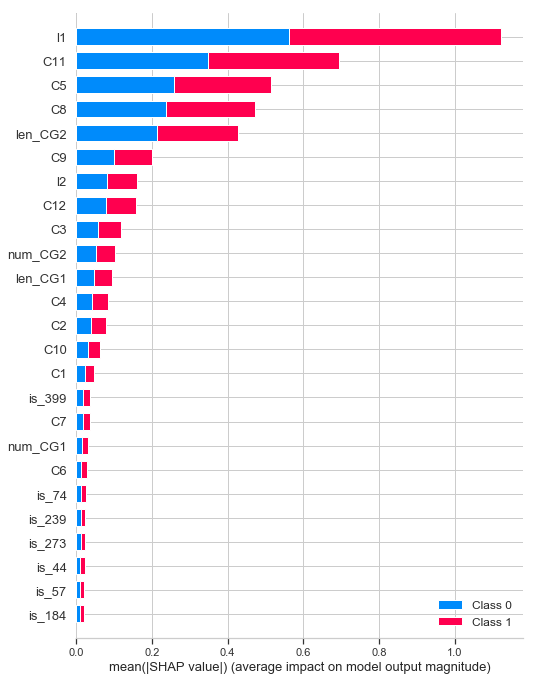

In [32]:
shap_test = shap.TreeExplainer(model).shap_values(X_tr)
shap.summary_plot(shap_test, X_tr,
                      max_display=25, auto_size_plot=True)

In [44]:
shap_test2 = np.abs(shap_test)
shap_test2 = shap_test2.mean(axis=0)

In [59]:
imps = pd.DataFrame({'col':X_tr.columns, 'val':shap_test2}).sort_values(by=['val'], ascending=False)

In [58]:
imps.to_pickle('imps')

### Parameter optimization

Обучим модель только на важных фичах на всём датафрейме после undersamplinga

In [83]:
cols = list(imps[imps.val>0.003]['col'])
cols

['l1',
 'C11',
 'C5',
 'C8',
 'len_CG2',
 'C9',
 'l2',
 'C12',
 'C3',
 'num_CG2',
 'len_CG1',
 'C4',
 'C2',
 'C10',
 'C1',
 'is_399',
 'C7',
 'num_CG1',
 'C6',
 'is_74',
 'is_239',
 'is_273',
 'is_44',
 'is_57',
 'is_184',
 'is_43',
 'is_124',
 'is_408',
 'is_130',
 'is_249',
 'is_137',
 'is_395',
 'len_CG3',
 'is_186',
 'is_59',
 'is_246',
 'is_306',
 'is_58',
 'is_151',
 'is_69',
 'is_353',
 'is_343',
 'is_252',
 'is_51',
 'is_376',
 'is_100',
 'is_304',
 'is_49',
 'is_251',
 'is_17',
 'is_181',
 'is_340',
 'is_10',
 'is_188',
 'is_422',
 'is_14',
 'is_18',
 'is_103',
 'is_216',
 'is_60',
 'is_26',
 'is_96',
 'is_418',
 'is_331',
 'is_61',
 'is_449',
 'is_113',
 'is_416',
 'is_16',
 'is_236',
 'is_267',
 'is_357',
 'is_36',
 'is_341',
 'is_382',
 'is_93',
 'is_268',
 'is_79',
 'is_435',
 'is_65',
 'is_180',
 'is_84',
 'is_21',
 'is_419',
 'is_123',
 'is_153',
 'is_77',
 'is_276',
 'is_52',
 'is_322',
 'is_138',
 'is_53',
 'is_24',
 'is_371',
 'is_152',
 'is_161',
 'is_381',
 'is_150',
 'is_82',
 'is_31',
 'is_81',
 'is_50',
 'is_102',
 'is_25',
 'is_177',
 'is_23',
 'is_47',
 'is_88',
 'is_19',
 'is_250',
 'is_222',
 'is_40',
 'is_330',
 'is_73',
 'is_37',
 'is_42',
 'is_63',
 'is_106',
 'is_27',
 'is_20',
 'is_325',
 'is_67',
 'is_270',
 'is_56',
 'is_30',
 'is_411',
 'is_438',
 'is_386',
 'is_118',
 'is_279',
 'is_205',
 'is_420',
 'is_247',
 'is_356',
 'is_29',
 'is_277',
 'is_375',
 'is_85',
 'is_148',
 'is_218',
 'is_228',
 'is_80',
 'is_83']

In [6]:
X_train = pd.read_pickle('X_tr')
X_train.shape

(1572006, 480)

In [6]:
X_tr, X_test, y_tr, y_test = train_test_split(X_train, y_train, test_size=0.25, random_state=123)

In [ ]:
X_tr = X_tr[cols]
X_test = X_test[cols]
X_tr.shape, y_tr.shape, y_tr.sum()

In [7]:
del X_train

In [39]:
space = {
            'max_depth': hp.quniform("max_depth", 5, 15, 1),
            'num_iterations': hp.quniform("num_iterations", 200, 800, 100),
            'learning_rate': hp.loguniform('learning_rate', -4, -2.5),
            'num_leaves': hp.quniform("num_leaves", 16, 128, 1),
            'bagging_fraction': hp.quniform("bagging_fraction", 0.5, 1, 0.1),
            'min_data_in_leaf': hp.quniform("min_data_in_leaf", 20, 40, 1),
            'feature_fraction': hp.quniform("feature_fraction", 0.5, 1, 0.1)   
        }

In [40]:
def get_gboost_params(space):
    params = dict()
    params['feature_fraction'] = space['feature_fraction']
    params['max_depth'] = space['max_depth']
    params['min_data_in_leaf'] = space['min_data_in_leaf']
    params['learning_rate'] = space['learning_rate']
    params['num_leaves'] = space['num_leaves']
    params['bagging_fraction'] = space['bagging_fraction']
    params['num_iterations'] = space['num_iterations']
    return params

In [41]:
def objective4(space):
    global obj_call_count, cur_best_loss

    obj_call_count += 1

    print('\nLightGBM objective call #{} cur_best_loss={:7.5f}'.format(obj_call_count, cur_best_loss) )

    params = get_gboost_params(space) #pyll.stochastic.sample(space)#

    sorted_params = sorted(space.items(), key=lambda z: z[0])
    params_str = str.join(' ', ['{}={}'.format(k, v) for k, v in sorted_params])
    print('Params: {}'.format(params_str) )

    lgb_params = {
               'feature_fraction': params['feature_fraction'],
               'metric': 'binary_logloss',
               'nthread':7, 
               'min_data_in_leaf': int(params['min_data_in_leaf']), 
               'learning_rate': params['learning_rate'], 
               'objective': 'binary', 
               'bagging_seed': 2**7, 
               'num_leaves': int(params['num_leaves']),
               'bagging_fraction': params['bagging_fraction'],
               'max_depth': int(params['max_depth']),
        'num_iterations': int(params['num_iterations'])
              }
    
    X_training, X_testing, y_training, y_testing = train_test_split(X_tr, y_tr, test_size=0.3)
    
    model = lgb.train(lgb_params, lgb.Dataset(X_training, label=y_training))
    
    tr_roc = log_loss(y_training, model.predict(X_training))
    test_roc = log_loss(y_testing, model.predict(X_testing))


    test_loss = test_roc
    
    if test_loss < cur_best_loss:
        cur_best_loss = test_loss
        
        print(colorama.Fore.GREEN + 'NEW BEST LOSS={}'.format(cur_best_loss) + colorama.Fore.RESET)
    
    print("Time from beginning = {} hour {} min {} sec".format(np.floor((time.clock() - st_time) /3600,),
                                np.floor((time.clock() - st_time)/60) - 60 * np.floor((time.clock() - st_time) /3600,),
                                np.round((time.clock() - st_time) - 60 * np.floor((time.clock() - st_time)/60), 5)))
    print("\nTr = {}\n Test = {}\n". format(tr_roc, test_roc))
    print("\nCurrent LOSS = ", test_loss, "\n")
    return({'loss':cur_best_loss, 'status': STATUS_OK })

In [15]:
N_HYPEROPT_PROBES = 150

obj_call_count = 0
cur_best_loss = np.inf
cur_best_roc = np.inf
st_time = time.clock()

# алгоритм сэмплирования гиперпараметров
HYPEROPT_ALGO = tpe.suggest  #  tpe.suggest OR hyperopt.rand.suggest

trials = Trials()
best4 = hyperopt.fmin(fn = objective4,
                     space = space,
                     algo = tpe.suggest,
                     max_evals = N_HYPEROPT_PROBES,
                     trials = trials
                    )


LightGBM objective call #1 cur_best_loss=    inf
Params: bagging_fraction=0.8 feature_fraction=0.5 learning_rate=0.02204076722916183 max_depth=6.0 min_data_in_leaf=36.0 num_iterations=700.0 num_leaves=76.0
NEW BEST LOSS=0.14034602424854514
Time from beginning = 0.0 hour 2.0 min 43.17708 sec

Tr = 0.13584273227041643
 Test = 0.14034602424854514


Current LOSS =  0.14034602424854514 


LightGBM objective call #2 cur_best_loss=0.14035
Params: bagging_fraction=1.0 feature_fraction=0.9 learning_rate=0.03656346194615646 max_depth=11.0 min_data_in_leaf=29.0 num_iterations=400.0 num_leaves=114.0
NEW BEST LOSS=0.13962166956586491
Time from beginning = 0.0 hour 5.0 min 9.90819 sec

Tr = 0.12391207588129168
 Test = 0.13962166956586491


Current LOSS =  0.13962166956586491 


LightGBM objective call #3 cur_best_loss=0.13962
Params: bagging_fraction=0.6000000000000001 feature_fraction=0.6000000000000001 learning_rate=0.05459557075182548 max_depth=12.0 min_data_in_leaf=25.0 num_iterations=700.0 num

Params: bagging_fraction=0.5 feature_fraction=0.7000000000000001 learning_rate=0.047229542207160184 max_depth=15.0 min_data_in_leaf=30.0 num_iterations=300.0 num_leaves=114.0
Time from beginning = 1.0 hour 43.0 min 54.56933 sec

Tr = 0.12416293658889424
 Test = 0.1385509473429286


Current LOSS =  0.1385509473429286 


LightGBM objective call #46 cur_best_loss=0.13776
Params: bagging_fraction=0.6000000000000001 feature_fraction=0.9 learning_rate=0.03882166030391122 max_depth=7.0 min_data_in_leaf=29.0 num_iterations=400.0 num_leaves=69.0
Time from beginning = 1.0 hour 46.0 min 7.61915 sec

Tr = 0.1322726074406473
 Test = 0.13977545696592297


Current LOSS =  0.13977545696592297 


LightGBM objective call #47 cur_best_loss=0.13776
Params: bagging_fraction=0.9 feature_fraction=0.5 learning_rate=0.032273398992816595 max_depth=8.0 min_data_in_leaf=30.0 num_iterations=800.0 num_leaves=62.0
Time from beginning = 1.0 hour 49.0 min 0.61059 sec

Tr = 0.12733861553904643
 Test = 0.139117267749610



Current LOSS =  0.13882747610045792 


LightGBM objective call #90 cur_best_loss=0.13702
Params: bagging_fraction=0.8 feature_fraction=0.8 learning_rate=0.04401782708327266 max_depth=8.0 min_data_in_leaf=25.0 num_iterations=800.0 num_leaves=89.0
Time from beginning = 3.0 hour 30.0 min 3.68393 sec

Tr = 0.11565075528332795
 Test = 0.1393741618835376


Current LOSS =  0.1393741618835376 


LightGBM objective call #91 cur_best_loss=0.13702
Params: bagging_fraction=0.8 feature_fraction=0.8 learning_rate=0.04086825540367693 max_depth=8.0 min_data_in_leaf=26.0 num_iterations=800.0 num_leaves=89.0
Time from beginning = 3.0 hour 33.0 min 42.19797 sec

Tr = 0.11745109107366582
 Test = 0.1391324597587863


Current LOSS =  0.1391324597587863 


LightGBM objective call #92 cur_best_loss=0.13702
Params: bagging_fraction=0.8 feature_fraction=0.8 learning_rate=0.039317336375625775 max_depth=7.0 min_data_in_leaf=26.0 num_iterations=800.0 num_leaves=114.0
Time from beginning = 3.0 hour 37.0 min 42.18

Params: bagging_fraction=0.5 feature_fraction=0.7000000000000001 learning_rate=0.036303274462200275 max_depth=9.0 min_data_in_leaf=20.0 num_iterations=800.0 num_leaves=99.0
Time from beginning = 5.0 hour 40.0 min 23.38473 sec

Tr = 0.11646520557500874
 Test = 0.13922140492536983


Current LOSS =  0.13922140492536983 


LightGBM objective call #135 cur_best_loss=0.13702
Params: bagging_fraction=0.6000000000000001 feature_fraction=0.6000000000000001 learning_rate=0.03701936171225758 max_depth=9.0 min_data_in_leaf=21.0 num_iterations=800.0 num_leaves=108.0
Time from beginning = 5.0 hour 43.0 min 43.45304 sec

Tr = 0.1154682879101786
 Test = 0.13870775907570765


Current LOSS =  0.13870775907570765 


LightGBM objective call #136 cur_best_loss=0.13702
Params: bagging_fraction=0.6000000000000001 feature_fraction=0.6000000000000001 learning_rate=0.045263547133440316 max_depth=9.0 min_data_in_leaf=21.0 num_iterations=800.0 num_leaves=112.0
Time from beginning = 5.0 hour 46.0 min 59.42314 sec


In [16]:
best4

{'bagging_fraction': 0.7000000000000001,
 'feature_fraction': 0.8,
 'learning_rate': 0.040825478047257745,
 'max_depth': 8.0,
 'min_data_in_leaf': 26.0,
 'num_iterations': 700.0,
 'num_leaves': 90.0}

### Modelling

In [9]:
lgb_params = {
               'bagging_fraction': 0.7,
               'feature_fraction': 0.8,
               'learning_rate': 0.040825478047257745, 
                'max_depth': 8,
               'min_data_in_leaf': 26, 
               'num_leaves': 90, 
               'metric': 'binary_logloss',
               'nthread':7, 
               'objective': 'binary', 
               'bagging_seed': 2**6, 
                'num_iterations': 10000,
               'verbose':20 
              }

In [13]:
model = lgb.train(lgb_params, lgb.Dataset(X_tr, label=y_tr), valid_sets=lgb.Dataset(X_test, label=y_test),
                  early_stopping_rounds=50, verbose_eval=50)

Training until validation scores don't improve for 50 rounds.
[50]	valid_0's binary_logloss: 0.144502
[100]	valid_0's binary_logloss: 0.140944
[150]	valid_0's binary_logloss: 0.139806
[200]	valid_0's binary_logloss: 0.139098
[250]	valid_0's binary_logloss: 0.138628
[300]	valid_0's binary_logloss: 0.138308
[350]	valid_0's binary_logloss: 0.13808
[400]	valid_0's binary_logloss: 0.13787
[450]	valid_0's binary_logloss: 0.137775
[500]	valid_0's binary_logloss: 0.137624
[550]	valid_0's binary_logloss: 0.137488
[600]	valid_0's binary_logloss: 0.137424
[650]	valid_0's binary_logloss: 0.137316
[700]	valid_0's binary_logloss: 0.137209
[750]	valid_0's binary_logloss: 0.137135
[800]	valid_0's binary_logloss: 0.137049
[850]	valid_0's binary_logloss: 0.136992
[900]	valid_0's binary_logloss: 0.136946
[950]	valid_0's binary_logloss: 0.136899
[1000]	valid_0's binary_logloss: 0.136815
[1050]	valid_0's binary_logloss: 0.13674
[1100]	valid_0's binary_logloss: 0.136707
[1150]	valid_0's binary_logloss: 0.13

### Feature eliminating

In [14]:
shap_test = shap.TreeExplainer(model).shap_values(X_tr[:100000])
shap_test2 = np.abs(shap_test)
shap_test2 = shap_test2.mean(axis=0)
imps = pd.DataFrame({'col':X_tr.columns, 'val':shap_test2}).sort_values(by=['val'], ascending=False)

In [37]:
cls = list(imps[imps.val>0.009]['col'])
print(len(cls))
cls

40


['l1',
 'C8',
 'C11',
 'C5',
 'len_CG2',
 'C3',
 'C9',
 'C12',
 'l2',
 'num_CG2',
 'len_CG3',
 'C4',
 'len_CG1',
 'C2',
 'C10',
 'C7',
 'C1',
 'is_279',
 'is_276',
 'is_246',
 'num_CG1',
 'is_399',
 'is_306',
 'is_422',
 'is_74',
 'is_186',
 'is_381',
 'is_93',
 'is_267',
 'is_130',
 'is_49',
 'is_43',
 'is_58',
 'is_57',
 'is_124',
 'is_239',
 'is_181',
 'is_180',
 'C6',
 'is_340']

In [33]:
model3 = lgb.train(lgb_params, lgb.Dataset(X_tr[cls], label=y_tr), valid_sets=lgb.Dataset(X_test[cls], label=y_test),
                  early_stopping_rounds=50, verbose_eval=50)

Training until validation scores don't improve for 50 rounds.
[50]	valid_0's binary_logloss: 0.144564
[100]	valid_0's binary_logloss: 0.140902
[150]	valid_0's binary_logloss: 0.139662
[200]	valid_0's binary_logloss: 0.13888
[250]	valid_0's binary_logloss: 0.138396
[300]	valid_0's binary_logloss: 0.138012
[350]	valid_0's binary_logloss: 0.137762
[400]	valid_0's binary_logloss: 0.137609
[450]	valid_0's binary_logloss: 0.137427
[500]	valid_0's binary_logloss: 0.137297
[550]	valid_0's binary_logloss: 0.137192
[600]	valid_0's binary_logloss: 0.137013
[650]	valid_0's binary_logloss: 0.136919
[700]	valid_0's binary_logloss: 0.136845
[750]	valid_0's binary_logloss: 0.136759
[800]	valid_0's binary_logloss: 0.136715
[850]	valid_0's binary_logloss: 0.136628
[900]	valid_0's binary_logloss: 0.13662
[950]	valid_0's binary_logloss: 0.136575
[1000]	valid_0's binary_logloss: 0.136563
[1050]	valid_0's binary_logloss: 0.136542
[1100]	valid_0's binary_logloss: 0.136537
[1150]	valid_0's binary_logloss: 0.1

In [9]:
X_tr = X_tr[cls]
X_test = X_test[cls]
X_tr.shape, X_test.shape

((1179004, 40), (393002, 40))

Переобучаем на всех данных

In [24]:
lgb_params = {
               'bagging_fraction': 0.7,
               'feature_fraction': 0.8,
               'learning_rate': 0.040825478047257745, 
                'max_depth': 8,
               'min_data_in_leaf': 26, 
               'num_leaves': 90, 
               'metric': 'binary_logloss',
               'nthread':7, 
               'objective': 'binary', 
               'bagging_seed': 2**6, 
                'num_iterations': 1235,
               'verbose':20 
              }
model33 = lgb.train(lgb_params, lgb.Dataset(pd.concat([X_tr, X_test]), label=pd.concat([y_tr, y_test])))

In [47]:
joblib.dump(model33, 'model_best_solution_last')

['model_best_solution_last']

### Test Dataset preparation

In [63]:
df_test = pd.read_csv('data/test-data.tar.gz', compression='gzip', header=0, sep=',', quotechar='"', index_col=0)

In [64]:
df_test.shape

(1317220, 19)

In [65]:
df_test.head()

,test.csv,label,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,CG1,CG2,CG3,l1,l2,C11,C12
0,1379538000,-1,4210358866,3196051971,3336,2094,22,995,0,361,15,566,"176,213,220,222,224,47,422,103,419,74,3,235,23...",NaN,NaN,0,0,0,103
1,1379538000,-1,2248128334,3994996972,393,16232,52,995,2,8,15,821,"379,384,98,96,215,224,186,188,183,184,49,50,47...","17179,3883,20334,20333,25423,5318,10989,8668,2...",NaN,6,0,0,104
2,1379538000,-1,2323433900,1100964395,4454,34157,11,995,2,361,15,672,"243,380,269,420,363,31,18,214,331,60,58,306,19...",NaN,NaN,48,0,0,106
3,1379538000,-1,3430094722,1690426382,5919,6384,25,2658,0,390,22,722,"448,277,276,275,99,154,155,76,412,139,333,332,...","22337,2002","43074,43841,45509,45500,33701,54846,38344,1159...",2,0,1,106
4,1379538000,-1,3531271529,3678868632,1169,26182,30,995,0,94,15,1131,"273,170,205,204,174,173,248,384,382,381,92,97,...",16129,NaN,23,0,0,104


In [66]:
df_test = df_test[df_test.columns[2:]]
df_test = preproc(df_test)
df_test.to_pickle('df_test')
df_test.head()

,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,...,is_450,is_451,is_452,is_453,is_454,is_455,is_456,is_457,is_458,is_459
0,4210358866,3196051971,3336,2094,22,995,0,361,15,566,...,0,0,0,0,0,0,0,0,0,0
1,2248128334,3994996972,393,16232,52,995,2,8,15,821,...,0,0,0,0,0,0,0,0,0,0
2,2323433900,1100964395,4454,34157,11,995,2,361,15,672,...,0,0,0,0,0,0,0,0,0,0
3,3430094722,1690426382,5919,6384,25,2658,0,390,22,722,...,0,0,0,0,0,0,0,0,0,0
4,3531271529,3678868632,1169,26182,30,995,0,94,15,1131,...,0,0,0,0,0,0,0,0,0,0


### Normalizing cutoff

In [12]:
# Определим корректную нормировку
tmp_test = pd.read_csv('data/train.tar.gz', compression='gzip', header=0, sep=';', quotechar='"', nrows=500000)
answ = tmp_test['label']
tmp_test = tmp_test[tmp_test.columns[2:]]
tmp_test = preproc(tmp_test)

In [25]:
pres2 = model33.predict(tmp_test[cls])

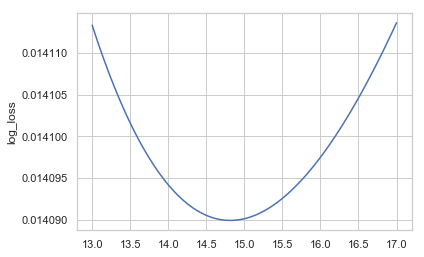

In [26]:
fs = []
grid = np.linspace(13,17,100)
for i in grid:
    fs.append(log_loss(answ, pres2/i))
plt.plot(grid, fs)
plt.ylabel('log_loss')
plt.show()

In [27]:
grid[np.argmin(fs)]

14.818181818181818

### Scoring test data

In [28]:
final4 = pd.DataFrame(model33.predict(df_test[X_tr.columns]))

In [29]:
final4[0] = final4[0] / grid[np.argmin(fs)]
final4.head()

,0
0,0.001686
1,0.000463
2,0.000603
3,0.011967
4,0.000291


In [30]:
final4.to_csv('solution_var2.csv', float_format='%.6f', index=False, header=0)

### Estimating

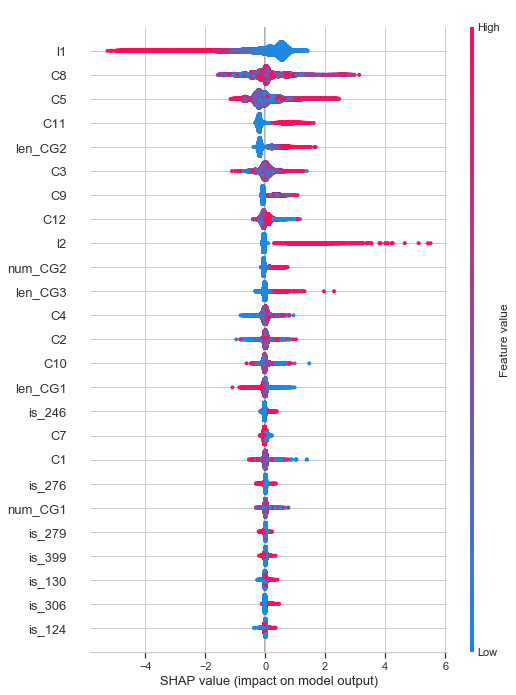

In [31]:
shap_test = shap.TreeExplainer(model33).shap_values(X_tr[:100000])
shap.summary_plot(shap_test, X_tr[:100000],
                      max_display=25, auto_size_plot=True)

In [33]:
preds = model33.predict(X_test)

[<matplotlib.lines.Line2D at 0x19c184583c8>]

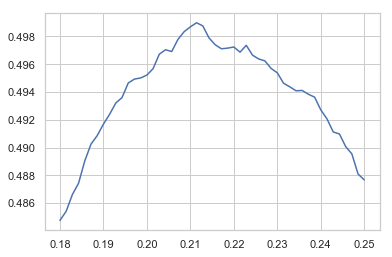

In [38]:
# Определим корректный cut-off
fs = []
grid = np.linspace(0.18,0.25,50)
for i in grid:
    fs.append(f1_score(y_test, preds>i))
plt.plot(grid, fs)

In [32]:
roc_auc_score(y_test, model33.predict(X_test))

0.9219859806863495

In [39]:
precision_score(y_test, preds>grid[np.argmax(fs)])

0.4645431609298973

In [40]:
recall_score(y_test, preds>grid[np.argmin(fs)]), f1_score(y_test, preds>grid[np.argmax(fs)])

(0.6079343508258416, 0.49898373983739835)